# Traducción de inglés a español con un Transformer de secuencia a secuencia
## English-to-Spanish translation with a sequence-to-sequence Transformer

**Author:** [fchollet](https://twitter.com/fchollet)<br>
**Date created:** 2021/05/26<br>
**Last modified:** 2023/02/25<br>
**Description:** Implementing a sequence-to-sequence Transformer and training it on a machine translation task.

**Revised and updated by:** Edgardo Bonzi   
**Updated on:** 2023/11/25

## Introducción

En este ejemplo, construiremos un modelo Transformer de secuencia a secuencia, que entrenaremos en una tarea de traducción automática del inglés al español.

Aprenderás cómo:

- Vectorizar el texto usando la capa Keras TextVectorization.
- Implementar una capa TransformerEncoder, una capa TransformerDecoder y una capa PositionalEmbedding.
- Preparar datos para entrenar un modelo secuencia a secuencia.
- Utilizar el modelo entrenado para generar traducciones de oraciones de entrada nunca antes vistas (inferencia secuencia a secuencia).

El código que se presenta aquí está adaptado del libro [Deep Learning with Python, Second Edition](https://www.manning.com/books/deep-learning-with-python-second-edition)
(chapter 11: Deep learning for text).  
El presente ejemplo es bastante básico, por lo que para obtener explicaciones detalladas de cómo funciona cada componente, así como la teoría detrás de Transformers, se recomienda leer el libro.

## Setup

In [1]:
"""
Estas sentencias se utilizan para configurar la variable de entorno "KERAS_BACKEND"
en el entorno de ejecución de Python.
---------------------------------------------------------------------------------
Esta línea importa el módulo os, que permite interactuar con el sistema operativo
utilizando Python.
"""
import os
"""
---------------------------------------------------------------------------------
Esta línea establece una variable de entorno llamada "KERAS_BACKEND" y la configura
con el valor "tensorflow".
"""
os.environ["KERAS_BACKEND"] = "tensorflow"
"""
---------------------------------------------------------------------------------
En el contexto de Keras, el parámetro "KERAS_BACKEND" se utiliza para especificar
qué backend se debe utilizar para las operaciones de Keras. Keras es una biblioteca
de alto nivel para la creación de redes neuronales, y puede funcionar con varios
backends, como TensorFlow, Theano o CNTK.

En este caso particular, se configura "tensorflow" como el backend de Keras.
Esto significa que las operaciones de Keras se ejecutarán utilizando TensorFlow
como motor subyacente para realizar los cálculos.

Esto es útil cuando se quiere asegurar que Keras utilice específicamente TensorFlow
como su backend para las operaciones de aprendizaje profundo en lugar de otros
motores o backends disponibles.
"""
## import os
## os.environ["KERAS_BACKEND"] = "tensorflow"

import pathlib
import random
import string
import re
import numpy as np

### Librerías de Python utilizadas

1. **`pathlib`:** Esta librería proporciona clases para interactuar con rutas de sistema de archivos de una manera más orientada a objetos. Permite manipular rutas de manera más eficiente y consistente. Algunas de las operaciones comunes incluyen la navegación entre directorios, la comprobación de la existencia de archivos o directorios, la obtención de información sobre rutas y nombres de archivo, entre otras. Es parte de la biblioteca estándar de Python y es útil para trabajar con rutas de archivos y directorios.

2. **`random`:** La librería `random` proporciona funciones para trabajar con números aleatorios. Puede generar números aleatorios enteros, de punto flotante, mezclar secuencias, elegir elementos aleatorios de una secuencia y más. Es útil para tareas que requieren aleatoriedad, como la selección aleatoria, la generación de datos de prueba o la mezcla de elementos.

3. **`string`:** La librería `string` proporciona constantes y funciones útiles para trabajar con cadenas de texto. Contiene constantes predefinidas para letras mayúsculas y minúsculas, dígitos, puntuación y otros grupos de caracteres. También ofrece funciones para formatear, manipular y trabajar con cadenas de texto, como la conversión entre mayúsculas y minúsculas, la eliminación de espacios en blanco, entre otros.

4. **`re`:** La librería `re` proporciona operaciones de expresiones regulares en Python. Permite trabajar con patrones de texto para buscar, extraer y manipular cadenas de texto basadas en reglas específicas definidas por expresiones regulares. Ofrece funciones como `search`, `match`, `findall`, `sub`, entre otras, para realizar operaciones avanzadas de búsqueda y manipulación de cadenas basadas en patrones específicos. Las expresiones regulares son muy potentes y útiles para realizar operaciones complejas de coincidencia y manipulación de texto.

In [2]:
import tensorflow as tf
import keras
from keras import layers
from keras.layers import TextVectorization
from tensorflow.keras.models import load_model

## Descargando los datos

Trabajaremos con un conjunto de datos de traducción del inglés al español proporcionado por [Anki](https://www.manythings.org/anki/).  

Vamos a descargarlo:

In [3]:
text_file = keras.utils.get_file(
    fname="spa-eng.zip",
    origin="http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip",
    extract=True,
)
text_file = pathlib.Path(text_file).parent / "spa-eng" / "spa.txt"

2638744/2638744 [==============================] - 0s 0us/step
CPU times: user 76.1 ms, sys: 15.8 ms, total: 91.9 ms
Wall time: 207 ms


## Analizando los datos

Cada línea contiene una oración en inglés y su correspondiente oración en español.  
La oración en inglés es la *secuencia fuente* y la oración en español es la *secuencia objetivo*.  
En esta celda, anteponemos el token `"[start]"` y agregamos el token `"[end]"` a la oración en español.

In [4]:
with open(text_file) as f:
    lines = f.read().split("\n")[:-1]

text_pairs = []
for line in lines:
    eng, spa = line.split("\t")
    spa = "[start] " + spa + " [end]"
    text_pairs.append((eng, spa))

Así es como se ven nuestros pares de oraciones:

In [5]:
for _ in range(5):
    print(random.choice(text_pairs))

('I like to dance with Mary.', '[start] Me gusta bailar con Mary. [end]')
('Life is enjoyable.', '[start] La vida es divertida. [end]')
("Tom couldn't find what he was looking for.", '[start] Tom no pudo encontrar lo que estaba buscando. [end]')
('The meeting took place yesterday.', '[start] La reunión tuvo lugar ayer. [end]')
('The pond is 3 meters deep.', '[start] La laguna tiene 3 metros de profundidad. [end]')


Ahora, dividamos los pares de oraciones en un conjunto de entrenamiento, un conjunto de validación y un conjunto de prueba.

In [6]:
random.shuffle(text_pairs)
num_val_samples = int(0.15 * len(text_pairs))
num_train_samples = len(text_pairs) - 2 * num_val_samples

# primeros 70 %
train_pairs = text_pairs[:num_train_samples]
# del 70 % al 85 %
test_pairs = text_pairs[num_train_samples + num_val_samples :]
# últimos 15 %
val_pairs = text_pairs[num_train_samples : num_train_samples + num_val_samples]


print(f"{len(text_pairs)} total pairs")
print(f"{len(train_pairs)} training pairs")
print(f"{len(val_pairs)} validation pairs")
print(f"{len(test_pairs)} test pairs")

118964 total pairs
83276 training pairs
17844 validation pairs
17844 test pairs


## Vectorizando los datos del texto

Usaremos dos instancias de la capa `TextVectorization` para vectorizar los datos de texto (una para inglés y otra para español), es decir, convertir las cadenas originales en secuencias de números enteros donde cada número entero representa el índice de una palabra en un vocabulario.

La capa en inglés utilizará la estandarización de cadenas predeterminada (eliminar caracteres de puntuación) y esquema de división (dividido en espacios en blanco), mientras que la capa española usará una estandarización personalizada, donde agregamos el carácter
`"¿"` al conjunto de caracteres de puntuación que se eliminarán.


In [7]:
"""
La línea strip_chars = strip_chars.replace("[", "") utiliza el método
replace() para modificar una cadena llamada strip_chars. Así es cómo funciona:

    strip_chars.replace("[", ""): Esta línea invoca el método replace() en la
    cadena strip_chars. La función replace() busca todos los caracteres que
    coinciden con el primer argumento (en este caso, el carácter "["), y los
    reemplaza con el segundo argumento (en este caso, una cadena vacía "", lo
    que significa eliminar esos caracteres).

    strip_chars = strip_chars.replace("[", ""): La línea completa asigna el
    resultado de la operación replace() de nuevo a la variable strip_chars.

    Esto significa que la cadena original strip_chars se modifica y reemplaza
    todas las ocurrencias del carácter "[" por una cadena vacía "" en sí misma.
    Similarmente sucede con el carácter "]".
"""
strip_chars = string.punctuation + "¿"
strip_chars = strip_chars.replace("[", "")
strip_chars = strip_chars.replace("]", "")

vocab_size = 15000
sequence_length = 20
batch_size = 64


def custom_standardization(input_string):
    lowercase = tf.strings.lower(input_string)
    return tf.strings.regex_replace(lowercase, "[%s]" % re.escape(strip_chars), "")

"""
La siguiente parte del código esta relacionada con la vectorización de texto
utilizando la clase TextVectorization de TensorFlow.

Ésta es la explicación de los parámetros utilizados:

    max_tokens=vocab_size:
    Este parámetro define la cantidad máxima de tokens únicos que se utilizarán
    en la vectorización. vocab_size representa el tamaño máximo del vocabulario,
    es decir, la cantidad máxima de palabras diferentes permitidas.

    output_mode="int":
    Este parámetro especifica el modo de salida de la vectorización.
    En este caso, se configura para que la salida sea una representación entera de
    las palabras/tokenes.

    output_sequence_length=sequence_length:
    Aquí se establece la longitud máxima de las secuencias de salida.
    'sequence_length' indica la longitud máxima que tendrá cada secuencia
    después de la vectorización.

En síntesis, esta configuración de 'TextVectorization' indica que se va a realizar
una vectorización de texto con un límite de tokens, se generarán representaciones
enteras para los tokens y se limitará la longitud de las secuencias de salida a un
tamaño específico (sequence_length).

"""
# Para el texto en inglés
eng_vectorization = TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length,
)

"""
    La siguiente sentencia es similar a la anterior, pero se le agrega el uso de la
      función definida "custom_standardization" (standardize=custom_standardization)
"""
# Para el texto en español
spa_vectorization = TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length + 1,
    standardize=custom_standardization,
)

"""
    train_eng_texts = [pair[0] for pair in train_pairs]:
    Esta línea crea una lista 'train_eng_texts' que contiene el primer elemento
    de cada par en 'train_pairs'.
    'train_pairs' es la lista de pares donde el primer elemento de cada par es un texto en inglés.

    Para realizar esta actividad, usamos un loop for 'condensado'
"""
train_eng_texts = [pair[0] for pair in train_pairs]
train_spa_texts = [pair[1] for pair in train_pairs]

"""
    eng_vectorization.adapt(train_eng_texts):
    La llamada al método adapt() ajusta el componente eng_vectorization
    basándose en los textos de entrenamiento en inglés proporcionados en
    'train_eng_texts'.
    Lo que esto hace es analizar los textos de entrenamiento para construir el
    vocabulario, tokenizar y preprocesar el texto según los parámetros
    previamente configurados en eng_vectorization.
    La adaptación permite que el componente aprenda del corpus de entrenamiento
    y ajuste su comportamiento (como el vocabulario y las transformaciones aplicadas)
    para que coincida mejor con los datos reales.
"""
eng_vectorization.adapt(train_eng_texts)
spa_vectorization.adapt(train_spa_texts)

A continuación, formatearemos nuestros conjuntos de datos.

En cada paso de entrenamiento, el modelo buscará predecir las palabras objetivo N+1 (y más allá) utilizando la oración fuente y las palabras objetivo 0 a N.

Como tal, el conjunto de datos de entrenamiento generará una tupla `(inputs, targets)`, donde:  

- _inputs_ es un diccionario con las claves `encoder_inputs` y `decoder_inputs`.  
`encoder_inputs` es la oración fuente vectorizada y `decoder_inputs` es la oración objetivo "hasta ahora", es decir, las palabras 0 a N utilizadas para predecir la palabra N+1 (y más allá) en la oración objetivo.  
- _target_ es el objetivo es la oración objetivo compensada por un paso: proporciona las siguientes palabras en la oración objetivo: lo que el modelo intentará predecir.

In [8]:
"""
La función `format_dataset` esta diseñada para dar formato a un conjunto de datos
que contiene textos en inglés (`eng`) y textos en español (`spa`).
Esta función se usa para preparar datos para un modelo de traducción automática.

Esto haca esta función:

1. 'eng = eng_vectorization(eng)' y 'spa = spa_vectorization(spa)':
   Estas líneas aplican la vectorización a los textos en inglés ('eng') y
   español ('spa').
   'eng_vectorization' y 'spa_vectorization' fueron definidaas anteriormente,
   son funciones que toman textos en su forma original y los transforman
   utilizando técnicas de vectorización con 'TextVectorization'.

2. 'return ({...}, ...)':
   La función retorna un diccionario y un tensor.
   En el diccionario, se espera que el tensor 'encoder_inputs' contenga los
   textos en inglés procesados, y el tensor 'decoder_inputs' contendrá los
   textos en español pero truncados por la derecha para su uso como entradas del
   decodificador.
   Además, el tensor retornado fuera del diccionario contiene los textos en
   español pero truncados por la izquierda para su uso como objetivos de salida
   del modelo.
"""
def format_dataset(eng, spa):
    eng = eng_vectorization(eng)
    spa = spa_vectorization(spa)
    return (
        {
            "encoder_inputs": eng,
            "decoder_inputs": spa[:, :-1],
        },
        spa[:, 1:],
    )


In [9]:
"""
Esta función crea un conjunto de datos en formato apropiado para entrenar un
modelo de aprendizaje automático de traducción, con pares de textos en inglés y español.

Esta es la explicación paso a paso de lo que hace esta función:

1. 'eng_texts, spa_texts = zip(*pairs)':
   'pairs' es una lista de pares de textos, donde el primer elemento de cada par
   corresponde a un texto en inglés y el segundo a un texto en español.
   'zip(*pairs)' desempaqueta estos pares en dos secuencias separadas:
   'eng_texts' (textos en inglés) y 'spa_texts' (textos en español).

2. 'eng_texts = list(eng_texts)' y 'spa_texts = list(spa_texts)':
      Convierte las secuencias de textos en inglés y español de tuplas a listas.

3. 'dataset = tf.data.Dataset.from_tensor_slices((eng_texts, spa_texts))':
      Crea un conjunto de datos TensorFlow 'dataset' a partir de las listas de
      textos en inglés y español. Usa 'from_tensor_slices' para generar un
      dataset a partir de los tensores 'eng_texts' y 'spa_texts'.

4. 'dataset = dataset.batch(batch_size)':
      Agrupa los elementos del dataset en lotes de tamaño 'batch_size'.

5. 'dataset = dataset.map(format_dataset)':
      Aplica la función `format_dataset` a cada elemento del dataset.
      Esta función 'format_dataset' posiblemente realiza algún tipo de
      preprocesamiento o transformación de los datos, como la vectorización de
      los textos, ajuste de longitudes, etc.

6. 'return dataset.cache().shuffle(2048).prefetch(16)':
      Devuelve el dataset con ciertas operaciones encadenadas:
   - 'cache()': Almacena en caché los datos en memoria, lo que puede acelerar el
      entrenamiento si se repite varias veces.
   - 'shuffle(2048)': Mezcla aleatoriamente los elementos del dataset utilizando
      un búfer de tamaño 2048 (tamaño del búfer de mezcla).
   - 'prefetch(16)': Carga lotes de datos adicionales (16 lotes, en este caso)
      en memoria antes de que se soliciten, lo que puede mejorar la velocidad de
      entrenamiento al permitir que la GPU o CPU acceda a los datos de forma más eficiente.
"""
def make_dataset(pairs):
    eng_texts, spa_texts = zip(*pairs)
    eng_texts = list(eng_texts)
    spa_texts = list(spa_texts)
    dataset = tf.data.Dataset.from_tensor_slices((eng_texts, spa_texts))
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(format_dataset)
    return dataset.cache().shuffle(2048).prefetch(16)


In [11]:
train_ds = make_dataset(train_pairs)
val_ds = make_dataset(val_pairs)

Veamos de manera rápida a las formas de las secuencias (tenemos lotes de 64 pares y todas las secuencias tienen 20 pasos):

In [12]:
for inputs, targets in train_ds.take(1):
    print(f'inputs["encoder_inputs"].shape: {inputs["encoder_inputs"].shape}')
    print(f'inputs["decoder_inputs"].shape: {inputs["decoder_inputs"].shape}')
    print(f"targets.shape: {targets.shape}")

inputs["encoder_inputs"].shape: (64, 20)
inputs["decoder_inputs"].shape: (64, 20)
targets.shape: (64, 20)


## Construyendo el modelo
1. `TransformerEncoder`
2. `PositionalEmbedding`
3. `TransformerDecoder`

Nuestro `Transformer` _`secuencia a secuencia`_ consta de un `TransformerEncoder` y un `TransformerDecoder` encadenados.   
Para que el modelo tenga en cuenta el orden de las palabras, también utilizamos una capa `PositionalEmbedding`.

La secuencia fuente se pasará al `TransformerEncoder`, que producirá una nueva representación de la misma. Esta nueva representación luego se pasará al `TransformerDecoder`, junto con la secuencia objetivo hasta el momento (palabras objetivo 0 a N).   

Luego, `TransformerDecoder` buscará predecir las siguientes palabras en la secuencia objetivo (N+1 y más).

Un detalle clave que hace esto posible es el enmascaramiento causal (consulte el método get_causal_attention_mask() en `TransformerDecoder`).  
El `TransformerDecoder` ve las secuencias completas a la vez y, por lo tanto, debemos asegurarnos de que solo use información de los tokens objetivo 0 a N al predecir el token N+1 (de lo contrario, podría usar información del futuro, lo que daría como resultado un modelo que no se puede utilizar en el momento de la inferencia).

In [13]:
"""
Esta clase 'TransformerEncoder' representa una capa de un modelo Transformer
para la etapa de codificación (encoder).

Aquí está la explicación de sus partes:

- '__init__': El método '__init__' inicializa los parámetros de la capa.
     Recibe como argumentos 'embed_dim', 'dense_dim' y 'num_heads', que
    representan la dimensionalidad de los embeddings, la dimensionalidad de las
    capas densas y el número de encabezado, respectivamente.

    En este método se definen las diferentes capas que componen la capa del encoder:
  - 'self.attention': Una capa de atención multi-cabeza ('layers.MultiHeadAttention')
     que usa el número de encabezados y la dimensionalidad del embedding para calcular
     la atención entre las diferentes partes de la secuencia de entrada.
  - 'self.dense_proj': Una secuencia de capas densas ('tf.keras.Sequential')
     compuesta por dos capas densas, una con una activación ReLU ('layers.Dense(dense_dim, activation="relu")')
     y otra sin activación ('layers.Dense(embed_dim)').
  - 'self.layernorm_1' y 'self.layernorm_2': Capas de normalización ('layers.LayerNormalization')
     aplicadas después de ciertas operaciones para estabilizar el entrenamiento.
  - 'self.supports_masking': Indica que esta capa admite el uso de máscaras durante
     el entrenamiento (para ocultar ciertas partes de las secuencias).

- 'call': El método 'call' define la lógica de cómo se propaga la entrada a través
    de la capa. Toma la entrada `inputs` y una máscara opcional 'mask'.
    Realiza los siguientes pasos:
  - Si hay una máscara, se prepara una máscara de relleno ('padding_mask') utilizando
    la máscara proporcionada.
  - Calcula la atención usando la capa de atención multi-cabeza entre la entrada y
    ella misma, aplicando la máscara de relleno si está presente.
  - Aplica normalización y proyección densa a la salida de la atención.
  - Retorna la salida de la segunda capa de normalización.

- 'get_config': El método 'get_config' devuelve la configuración de la capa,
   incluyendo los valores de 'embed_dim', 'dense_dim' y 'num_heads'.
"""
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.dense_proj = tf.keras.Sequential(
            [
                layers.Dense(dense_dim, activation="relu"),
                layers.Dense(embed_dim),
            ]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.supports_masking = True

    def call(self, inputs, mask=None):
        if mask is not None:
            padding_mask = tf.cast(mask[:, None, :], dtype="int32")
        else:
            padding_mask = None

        attention_output = self.attention(
            query=inputs, value=inputs, key=inputs, attention_mask=padding_mask
        )
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "embed_dim": self.embed_dim,
                "dense_dim": self.dense_dim,
                "num_heads": self.num_heads,
            }
        )
        return config


In [14]:
"""
Esta clase en TensorFlow representa una capa de incrustación posicional que se
usa comúnmente en modelos de atención o transformadores para incorporar información
sobre la posición de las palabras en una secuencia.

- '__init__': En el constructor '__init__', se definen dos capas de incrustación
   ('Embedding') para tokens y posiciones. Ambas capas tienen como entrada la
   dimensión del vocabulario y la longitud de la secuencia, respectivamente, y
   tienen la misma dimensión de incrustación (`embed_dim`). Se almacenan también
   los parámetros de la secuencia, tamaño de vocabulario y dimensión de incrustación
   para su uso posterior.

- 'call': En el método 'call', se calcula la incrustación posicional sumando las
   incrustaciones de tokens y posiciones. Los tokens se pasan a través de la capa
   de incrustación de tokens ('token_embeddings'), y las posiciones se generan usando
   'tf.range()' y luego se pasan a través de la capa de incrustación de posiciones
   ('position_embeddings'). Estas incrustaciones se suman elemento a elemento.

- 'compute_mask': Esta función se utiliza para generar una máscara que indica las
   posiciones en las que los tokens son diferentes de cero. Si la entrada es cero,
   se devuelve 'None'; de lo contrario, se devuelve una máscara booleana que indica
   los valores diferentes de cero.

- 'get_config': Devuelve la configuración de la capa, lo que permite reconstruir
   la capa con la misma configuración. Retorna un diccionario con la longitud de
   secuencia, tamaño del vocabulario y dimensión de incrustación.
"""
class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=vocab_size, output_dim=embed_dim
        )
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=embed_dim
        )
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(0, length, 1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        if mask is None:
            return None
        else:
            return tf.not_equal(inputs, 0)

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "sequence_length": self.sequence_length,
                "vocab_size": self.vocab_size,
                "embed_dim": self.embed_dim,
            }
        )
        return config



In [15]:
"""
Esta clase 'TransformerDecoder' representa una capa del decodificador de un
modelo de Transformer.
El decodificador en un modelo de Transformer es responsable de generar la salida secuencial,
basándose en la información generada por el codificador  y la salida previamente generada.

Esta es la explicación del código:

- '__init__': En el constructor '__init__', se inicializan varias capas necesarias
     para el decodificador. Esto incluye capas de atención ('attention_1' y 'attention_2')
     que permiten al decodificador enfocarse en diferentes partes de la entrada y las
     incrustaciones (`dense_proj`) que se utilizan para proyectar y transformar las características.

- 'call': En el método `call`, se lleva a cabo el cálculo del decodificador.
     Se genera una máscara de atención causal (`causal_mask`) que se utiliza para
     asegurar que en cada paso de tiempo, las predicciones futuras no se utilicen
     para generar la salida actual. Luego, se aplican capas de atención y normalización
     a los datos de entrada y a las salidas del codificador, y se realiza una proyección
     con la capa densa.

- 'get_causal_attention_mask': Este método crea una máscara de atención causal.
     Esta máscara se utiliza en la capa de atención para evitar que las posiciones
     futuras influyan en las posiciones actuales durante la generación de la secuencia.

- 'get_config': Este método devuelve la configuración de la capa. Devuelve un
     diccionario con los parámetros del decodificador.
"""
class TransformerDecoder(layers.Layer):
    def __init__(self, embed_dim, latent_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.latent_dim = latent_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.attention_2 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.dense_proj = tf.keras.Sequential(
            [
                layers.Dense(latent_dim, activation="relu"),
                layers.Dense(embed_dim),
            ]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()
        self.supports_masking = True

    def call(self, inputs, encoder_outputs, mask=None):
        causal_mask = self.get_causal_attention_mask(inputs)
        if mask is not None:
            padding_mask = tf.cast(mask[:, None, :], dtype="int32")
            padding_mask = tf.minimum(padding_mask, causal_mask)
        else:
            padding_mask = None

        attention_output_1 = self.attention_1(
            query=inputs, value=inputs, key=inputs, attention_mask=causal_mask
        )
        out_1 = self.layernorm_1(inputs + attention_output_1)

        attention_output_2 = self.attention_2(
            query=out_1,
            value=encoder_outputs,
            key=encoder_outputs,
            attention_mask=padding_mask,
        )
        out_2 = self.layernorm_2(out_1 + attention_output_2)

        proj_output = self.dense_proj(out_2)
        return self.layernorm_3(out_2 + proj_output)

    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, None]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1), tf.convert_to_tensor([1, 1])],
            axis=0,
        )
        return tf.tile(mask, mult)

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "embed_dim": self.embed_dim,
                "latent_dim": self.latent_dim,
                "num_heads": self.num_heads,
            }
        )
        return config


A continuación, ensamblamos el modelo de un extremo a otro.

In [10]:

vocab_size = 15000
sequence_length = 20
batch_size = 64


In [16]:
"""
Este código crea un modelo de Transformer para tareas de secuencia a secuencia.
Este es el desglose de lo que hace:

1. Definición de parámetros:
   Se definen los parámetros 'embed_dim', 'latent_dim' y 'num_heads', que representan
   la dimensión de incrustación, la dimensión latente y el número de cabezas de atención,
   respectivamente.

2. Creación del codificador:
   Se define el modelo del codificador. Utiliza la capa de entrada 'encoder_inputs'
   y se pasa a través de una capa de incrustación posicional ('PositionalEmbedding')
   que asigna incrustaciones a las entradas del codificador.

   Luego, pasa por la capa del codificador ('TransformerEncoder') para producir
   los 'encoder_outputs'. Este modelo del codificador se define utilizando la API
   funcional de Keras.

3. Creación del decodificador:
   Se define el modelo del decodificador. Utiliza las capas de entrada 'decoder_inputs'
   y 'encoded_seq_inputs'. Similar al codificador, las entradas del decodificador
   pasan a través de una capa de incrustación posicional ('PositionalEmbedding') y
   luego por la capa del decodificador ('TransformerDecoder').

   Después de eso, se aplica una capa de dropout y se pasa a través de una capa
   densa con activación softmax para generar las salidas del decodificador.

4. Modelo final del Transformer:
   Finalmente, se define el modelo global del Transformer, que toma las entradas
   del codificador y del decodificador ('encoder_inputs' y 'decoder_inputs') para
   generar las salidas del decodificador.

   Este modelo se construye utilizando la API funcional de Keras.

"""
# Estaas variables ya fueron definidas anteriormente
embed_dim = 256
latent_dim = 2048
num_heads = 8

# ------------------------------------------------------------------------------
encoder_inputs = keras.Input(shape=(None,), dtype="int64", name="encoder_inputs")

x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(encoder_inputs)

encoder_outputs = TransformerEncoder(embed_dim, latent_dim, num_heads)(x)
encoder = keras.Model(encoder_inputs, encoder_outputs)


# ------------------------------------------------------------------------------
decoder_inputs = keras.Input(shape=(None,), dtype="int64", name="decoder_inputs")
encoded_seq_inputs = keras.Input(shape=(None, embed_dim), name="decoder_state_inputs")

x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(decoder_inputs)
x = TransformerDecoder(embed_dim, latent_dim, num_heads)(x, encoded_seq_inputs)
x = layers.Dropout(0.5)(x)

decoder_outputs = layers.Dense(vocab_size, activation="softmax")(x)
decoder = keras.Model([decoder_inputs, encoded_seq_inputs], decoder_outputs)


# ------------------------------------------------------------------------------
decoder_outputs = decoder([decoder_inputs, encoder_outputs])
transformer = keras.Model(
    [encoder_inputs, decoder_inputs], decoder_outputs, name="transformer"
)

### Visualización de la arquitectura de un modelo de red neuronal
Estas lineas de código son útiles para visualizar la arquitectura de un modelo de red neuronal de TensorFlow Keras, mostrando las capas del modelo y cómo están conectadas. El archivo de imagen model_plot.png contendrá el diagrama generado del modelo.
Explicación de las siguientes líneas decódigo:

```Python
    from tensorflow.keras.utils import plot_model
```
    Importa la función plot_model de la biblioteca tensorflow.keras.utils. Esta función se utiliza para generar un diagrama visual del modelo.

```Python
    plot_model(transformer, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
```
    Genera un diagrama del modelo proporcionado como argumento (transformer en este caso) y lo guarda como una imagen llamada model_plot.png.

Los parámetros opcionales `show_shapes=True` y `show_layer_names=True` controlan si se muestran los detalles de las formas de las capas y los nombres de las capas, respectivamente, en el diagrama generado.

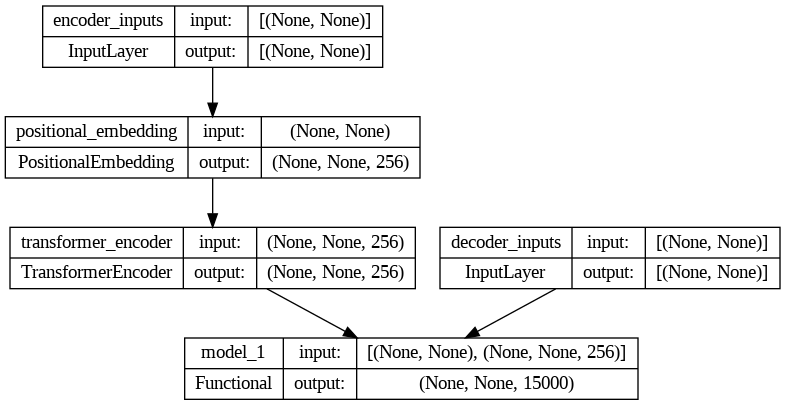

In [17]:
from tensorflow.keras.utils import plot_model
# Generar un diagrama del modelo y guardarlo como imagen
plot_model(transformer, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

## Entrenando nuestro modelo

Usaremos la precisión como una forma rápida de monitorear el progreso del entrenamiento en los datos de validación.
Tenga en cuenta que la traducción automática suele utilizar puntuaciones BLEU, así como otras métricas, en lugar de precisión.

Aquí solo entrenamos durante 1 época, pero para que el modelo realmente converja debes entrenar durante al menos 30 épocas.

## Puntuación BLEU (Bilingual Evaluation Understudy)
La puntuación BLEU (Bilingual Evaluation Understudy) es una métrica comúnmente utilizada para evaluar la calidad de las traducciones generadas por sistemas de traducción automática. Fue propuesta para proporcionar una medida automatizada de la calidad de las traducciones, en comparación con las evaluaciones manuales que pueden ser costosas y laboriosas de realizar.

El objetivo principal de BLEU es cuantificar qué tan cerca está una traducción automática de una referencia o un conjunto de referencias humanas (traducciones de alta calidad realizadas por humanos) para un determinado texto.

El proceso de cálculo de la puntuación BLEU implica los siguientes pasos:

1. **N-gram overlap:** Compara la similitud entre los n-gramas (secuencias de n palabras) en la traducción generada y las referencias humanas. Generalmente se utilizan n-gramas de longitud 1 a 4.

2. **Precision:** Evalúa qué porcentaje de los n-gramas en la traducción automática coinciden con los presentes en las referencias. Cuanto mayor sea la coincidencia, mayor será la puntuación de precisión.

3. **Brevity Penalty:** Penaliza las traducciones que son más cortas en comparación con las referencias, ya que una traducción muy corta podría tener una puntuación alta en precisión pero podría no ser una traducción adecuada.

La puntuación BLEU se calcula como un valor entre 0 y 1, donde 1 indica una coincidencia perfecta con las referencias humanas. Sin embargo, es importante tener en cuenta que la puntuación BLEU no es perfecta y puede no capturar todos los aspectos de la calidad de la traducción, ya que se centra principalmente en la similitud de los n-gramas y no en la comprensión semántica o la coherencia global del texto traducido.

## n-gramas
Los "n-gramas" son secuencias de palabras consecutivas tomadas de un texto, donde "n" representa el número de palabras en cada secuencia. Estos n-gramas son utilizados en procesamiento de lenguaje natural y análisis de texto para capturar la estructura y las características del lenguaje.

Por ejemplo:

- **Unigrama (1-grama):** Un unigrama consiste en una sola palabra. Por ejemplo, en la oración "El perro corre", los unigramas serían: "El", "perro", "corre".

- **Bigrama (2-grama):** Un bigrama consiste en secuencias de dos palabras consecutivas. Siguiendo el ejemplo anterior, los bigramas serían: "El perro", "perro corre".

- **Trigrama (3-grama):** Un trigrama consta de secuencias de tres palabras consecutivas. En la misma oración, los trigramas serían: "El perro corre".

- **Cuatrigrama (4-grama):** Un cuatrigrama se compone de secuencias de cuatro palabras consecutivas. Para la oración dada, solo hay un cuatrigrama: "El perro corre".

Estos n-gramas se utilizan en diversas aplicaciones de procesamiento de lenguaje natural, como modelos de lenguaje, traducción automática, extracción de características en análisis de texto, entre otros. La elección del valor de "n" determina el nivel de detalle o granularidad de las secuencias de palabras utilizadas para el análisis del texto.

In [ ]:
%%time
epochs = 40  # Esto debería ser al menos 30 para la convergencia.
            # El entrenamiento con 30 epochs lleva aprox. 50 minutos

transformer.summary()
transformer.compile(
    "rmsprop", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)
# CUIDADO AQUI ESTÁ COMENTADO PARA NO ENTRENAR DE NUEVO
# Descometar la siguiente linea para Entrenar la Red
transformer.fit(train_ds, epochs=epochs, validation_data=val_ds)

Model: "transformer"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_inputs (InputLayer  [(None, None)]               0         []                            
 )                                                                                                
                                                                                                  
 positional_embedding (Posi  (None, None, 256)            3845120   ['encoder_inputs[0][0]']      
 tionalEmbedding)                                                                                 
                                                                                                  
 decoder_inputs (InputLayer  [(None, None)]               0         []                            
 )                                                                                      

In [19]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [20]:
# Camino y nombre del Traslator entrenado
fileTraslator = 'gdrive/My Drive/Colab Notebooks/Curso NN/Traslator'

In [ ]:
"""
Aquí guardamos el Transformer entrenado
Si ya lo tenemos entrenado, entonces no hay que guardarlo, pues perderíamos todo
"""
transformer.save(fileTraslator)

In [21]:
"""
Aquí lo cargamos al Transformer
"""
# Cargar el modelo entrenado
transformer = load_model(fileTraslator)

## Decodificar oraciones de prueba

Finalmente, demostremos cómo traducir oraciones nuevas en inglés.  

Simplemente introducimos en el modelo la frase en inglés vectorizada, así como el token de destino `"[start]"`, luego generamos repetidamente el siguiente token, hasta que llegamos al token `"[end]"`.

In [22]:
spa_vocab = spa_vectorization.get_vocabulary()
spa_index_lookup = dict(zip(range(len(spa_vocab)), spa_vocab))
max_decoded_sentence_length = 20

def decode_sequence(input_sentence):
    tokenized_input_sentence = eng_vectorization([input_sentence])
    decoded_sentence = "[start]"
    for i in range(max_decoded_sentence_length):
        tokenized_target_sentence = spa_vectorization([decoded_sentence])[:, :-1]
        predictions = transformer([tokenized_input_sentence, tokenized_target_sentence])

        sampled_token_index = np.argmax(predictions[0, i, :])
        sampled_token = spa_index_lookup[sampled_token_index]
        decoded_sentence += " " + sampled_token

        if sampled_token == "[end]":
            break
    return decoded_sentence

In [23]:
test_eng_texts = [pair[0] for pair in test_pairs]
for _ in range(30):
    input_sentence = random.choice(test_eng_texts)
    print('Inglés  : ', input_sentence)
    translated = decode_sequence(input_sentence)
    print('Español :', translated)

Inglés  :  He saw a pretty girl.
Español : [start] los se [UNK] una ningún estudiando [end]
Inglés  :  He plays soccer.
Español : [start] los si traté [end]
Inglés  :  Let's hope Tom didn't do what you think he did.
Español : [start] [UNK] de tom lo que siempre bien voy [end]
Inglés  :  Please come downstairs.
Español : [start] yo [UNK] mi al tenemos [end]
Inglés  :  The customer agrees.
Español : [start] el carácter pelando [end]
Inglés  :  I always rest for an hour after dinner.
Español : [start] jugar viven por sabe hiciste de misma [end]
Inglés  :  You have only to answer the first question.
Español : [start] creo que del hace una sea [end]
Inglés  :  I'll never forget the sound the crash made.
Español : [start] por todos [UNK] que esa la tuve mi máquina [end]
Inglés  :  I was foolish enough to believe him.
Español : [start] si retrasó allí cuando al seguro [end]
Inglés  :  Five times five is twenty-five.
Español : [start] no son hablaba [UNK] [end]
Inglés  :  I hope I can go to Au

Después de 30 épocas, obtenemos resultados como:

> She handed him the money.
> [start] ella le pasó el dinero [end]

> Tom has never heard Mary sing.
> [start] tom nunca ha oído cantar a mary [end]

> Perhaps she will come tomorrow.
> [start] tal vez ella vendrá mañana [end]

> I love to write.
> [start] me encanta escribir [end]

> His French is improving little by little.
> [start] su francés va a [UNK] sólo un poco [end]

> My hotel told me to call you.
> [start] mi hotel me dijo que te [UNK] [end]

In [24]:
input_sentence = "Hello, thank you for to be in these lessons."
translated_sentence = decode_sequence(input_sentence)
print("Frase traducida:", translated_sentence)

Frase traducida: [start] a y levantó en que te común año a la levantó [end]
